# Introduction

dataset: https://github.com/nytimes/covid-19-data

# Import Packages

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error,mean_absolute_error

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA, ARMAResults, ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# Load Dataset

In [3]:
states_data = pd.read_csv('us-states.csv')

In [4]:
us_data = pd.read_csv('us.csv')

In [5]:
us_data.head()

date  cases  deaths
0  2020-01-21      1       0
1  2020-01-22      1       0
2  2020-01-23      1       0
3  2020-01-24      2       0
4  2020-01-25      3       0

In [6]:
# Calculate fatality rate
for i in states_data['deaths']:
    if i == 0:
        states_data['fatality_rate%'] = 0 
    else:
        states_data['fatality_rate%'] = 100*states_data['deaths']/states_data['cases']     

In [7]:
states_data.head()

date       state  fips  cases  deaths  fatality_rate%
0  2020-01-21  Washington    53      1       0             0.0
1  2020-01-22  Washington    53      1       0             0.0
2  2020-01-23  Washington    53      1       0             0.0
3  2020-01-24    Illinois    17      1       0             0.0
4  2020-01-24  Washington    53      1       0             0.0

In [8]:
states_data.isna().sum()

date              0
state             0
fips              0
cases             0
deaths            0
fatality_rate%    0
dtype: int64

# EDA

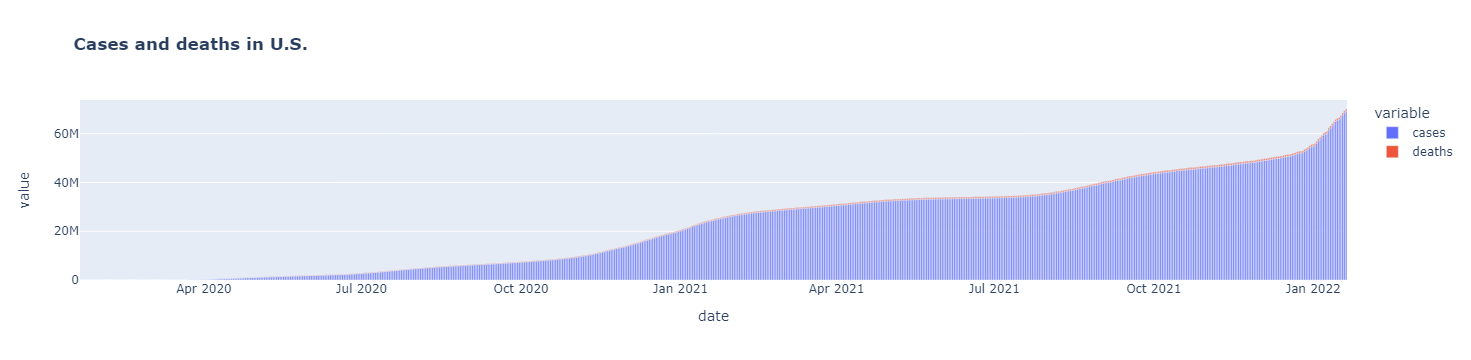

In [9]:
px.bar(data_frame=us_data, y=['cases','deaths'],x='date',title = '<b>Cases and deaths in U.S.<b>')

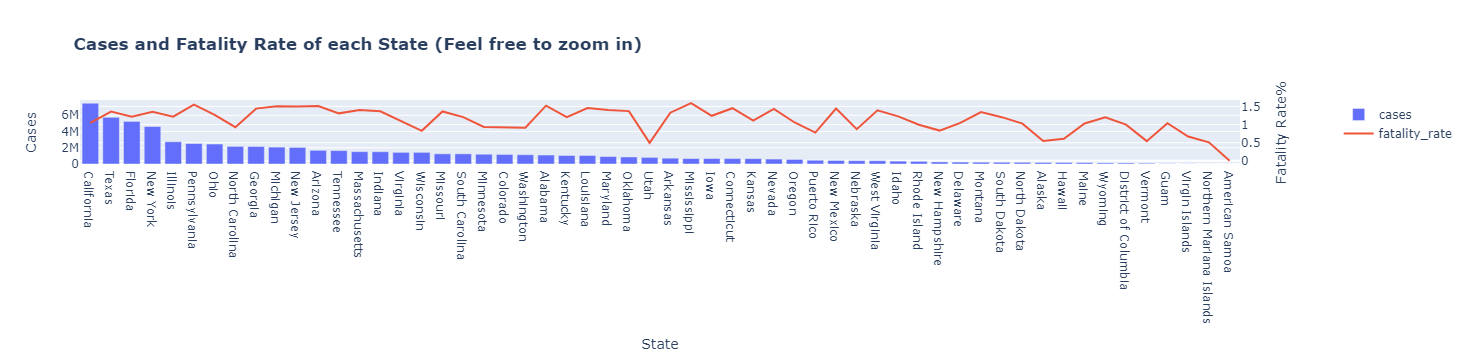

In [10]:
# Create states plot
state = states_data[states_data['date']==states_data['date'].max()].sort_values(by='cases',ascending=False)
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Bar(x=state['state'], y=state['cases'], name="cases"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=state['state'], y=state['fatality_rate%'], name="fatality_rate"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="<b>Cases and Fatality Rate of each State<b> (Feel free to zoom in)"
)

# Set x-axis title
fig.update_xaxes(title_text="State")

# Set y-axes titles
fig.update_yaxes(title_text="Cases", secondary_y=False)
fig.update_yaxes(title_text="Fatality Rate%", secondary_y=True)

fig.show()

## U.S. daily new cases

In [11]:
#Feature engineering in order to get new cases column
df = pd.read_csv('us.csv',index_col='date',parse_dates=True)
df.index.freq = 'D'
df['lag_one'] = df.cases.shift(1)
df['new_cases'] = df['cases'] - df['lag_one']
df = df[['new_cases']].iloc[1:]
df.head()

new_cases
date                 
2020-01-22        0.0
2020-01-23        0.0
2020-01-24        1.0
2020-01-25        1.0
2020-01-26        2.0

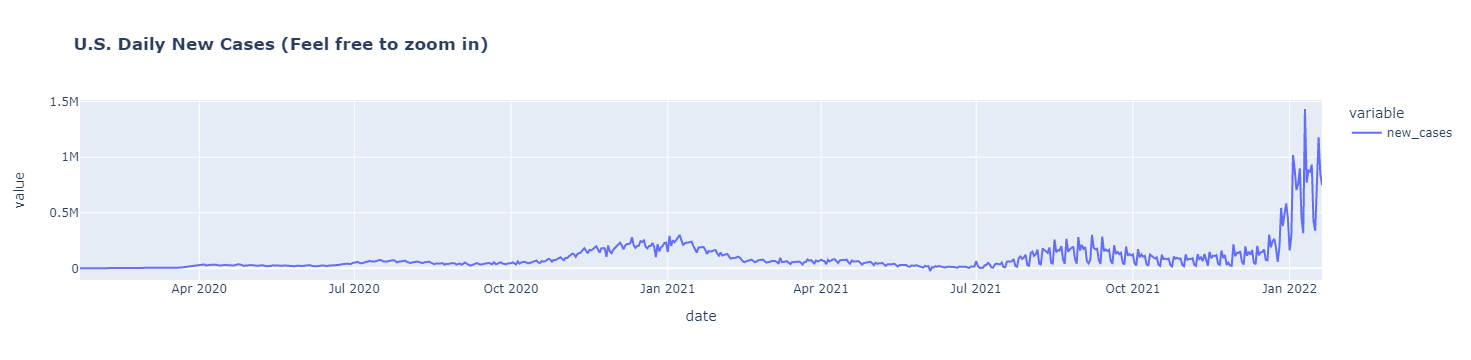

In [12]:
px.line(df, title = '<b>U.S. Daily New Cases<b> (Feel free to zoom in)')

# ETS Decomposition for the U.S. Dataset

In [13]:
df = pd.read_csv('us.csv',index_col='date',parse_dates=True)
df.index.freq = 'D'
df = df[['cases']]
df

cases
date                
2020-01-21         1
2020-01-22         1
2020-01-23         1
2020-01-24         2
2020-01-25         3
...              ...
2022-01-16  65814876
2022-01-17  66526927
2022-01-18  67705330
2022-01-19  68557114
2022-01-20  69305598

[731 rows x 1 columns]

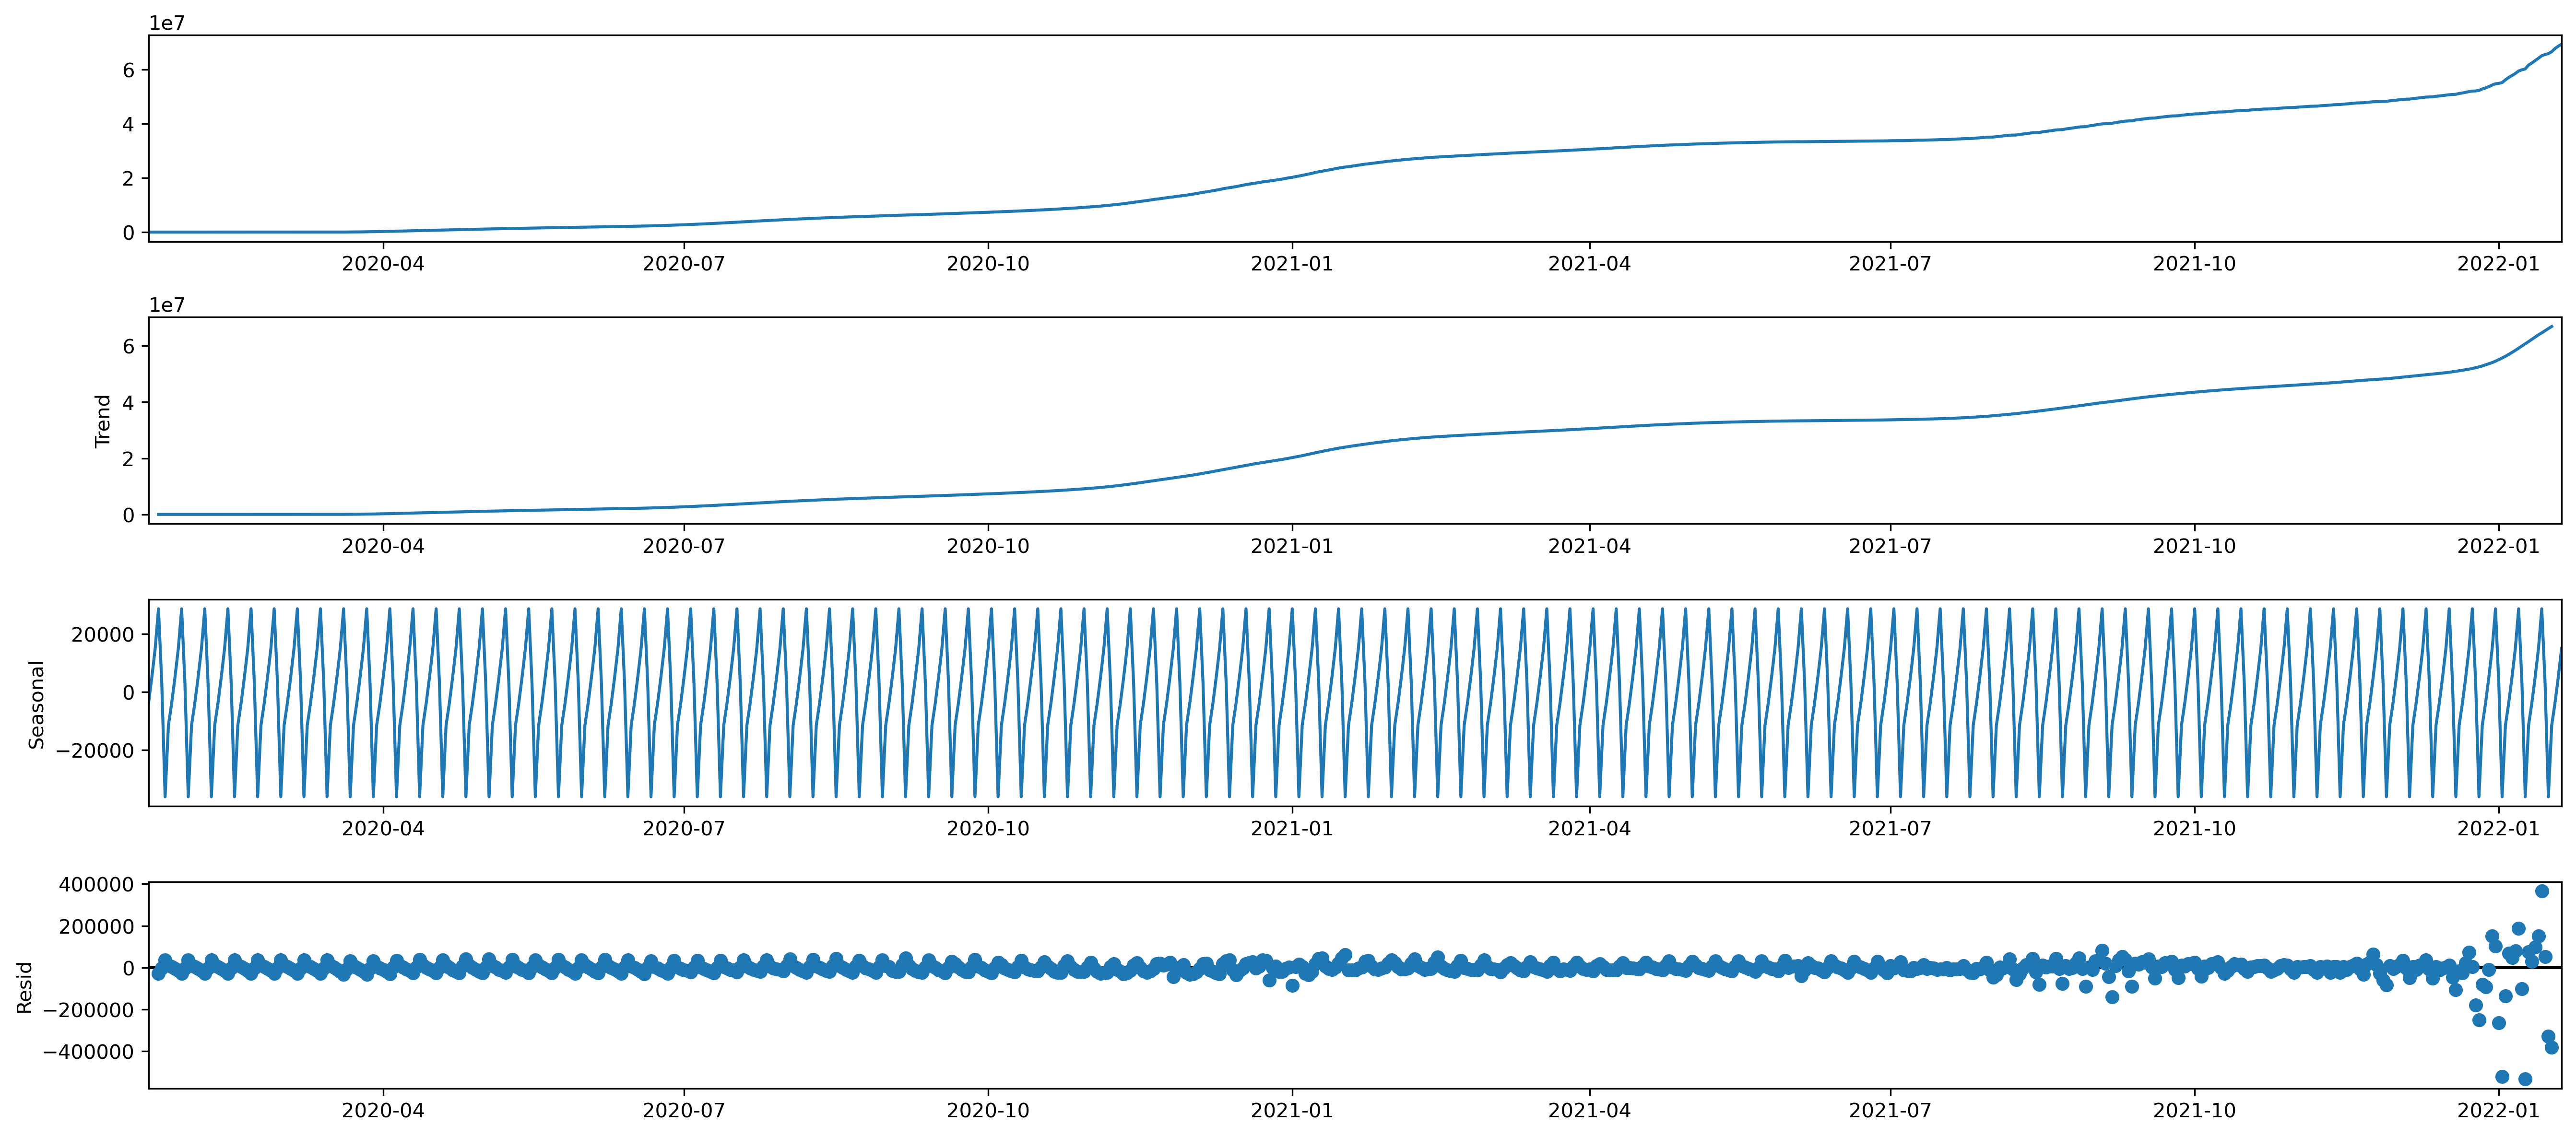

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 18,8
plt.rcParams['figure.dpi'] = 300
decomposition = seasonal_decompose(df,model='additive')
fig = decomposition.plot()
plt.show()

from pylab import rcParams
rcParams['figure.figsize'] = 18,8
plt.rcParams['figure.dpi'] = 300
decomposition = seasonal_decompose(df,model='multiplicative')
fig = decomposition.plot()
plt.show()

Here we see that the seasonal component does not contribute significantly to the behavior of the series.


## ARIMA

In [15]:
# Import Data again
df = pd.read_csv('us.csv',index_col='date',parse_dates=True)
df.index.freq = 'D'
df = df[['cases']]
df.head()

cases
date             
2020-01-21      1
2020-01-22      1
2020-01-23      1
2020-01-24      2
2020-01-25      3

### Check stationarity

Write a function that performs the augmented Dickey-Fuller Test.

In [16]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and" + color.BOLD + color.RED +" Stationary" + color.END)
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is" + color.BOLD + color.RED +" Non-Stationary" + color.END)

In [17]:
adf_test(df['cases'])

Augmented Dickey-Fuller Test: 
ADF test statistic        1.483984
p-value                   0.997464
# lags used              20.000000
# observations          710.000000
critical value (1%)      -3.439594
critical value (5%)      -2.865619
critical value (10%)     -2.568942
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is Non-Stationary


Augmented Dickey-Fuller Test: 
ADF test statistic        0.363481
p-value                   0.980077
# lags used              20.000000
# observations          709.000000
critical value (1%)      -3.439607
critical value (5%)      -2.865625
critical value (10%)     -2.568945
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is Non-Stationary


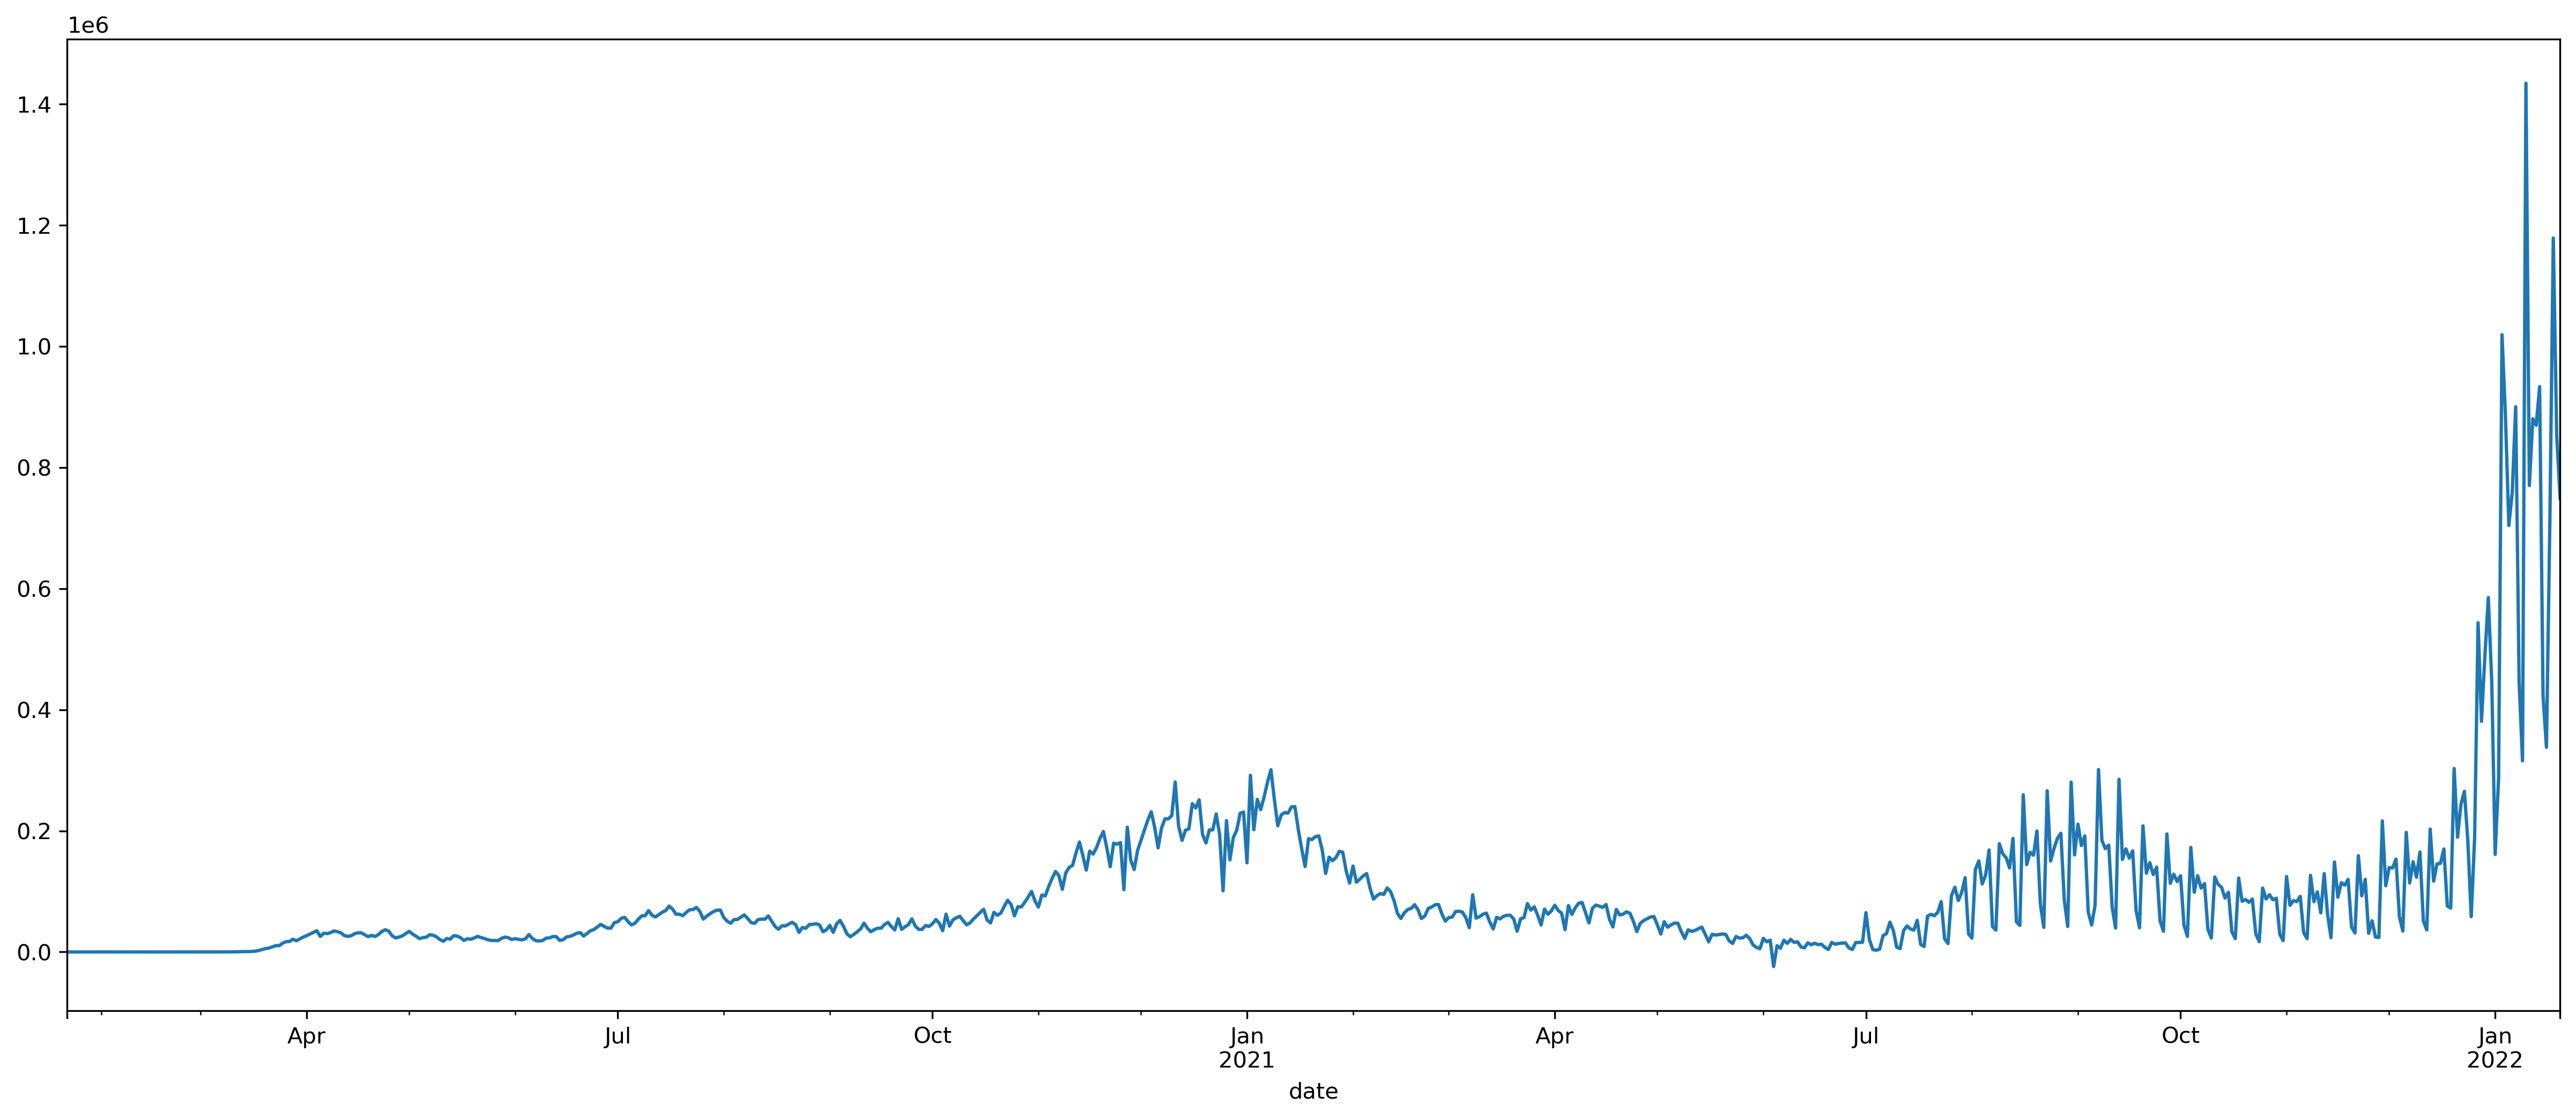

In [18]:
df['cases_diff1'] = df['cases'] - df['cases'].shift(1)
df['cases_diff1'].dropna().plot(figsize=(20, 8))
adf_test(df['cases_diff1'].dropna())

Augmented Dickey-Fuller Test: 
ADF test statistic       -4.742825
p-value                   0.000070
# lags used              20.000000
# observations          708.000000
critical value (1%)      -3.439620
critical value (5%)      -2.865631
critical value (10%)     -2.568948
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and Stationary


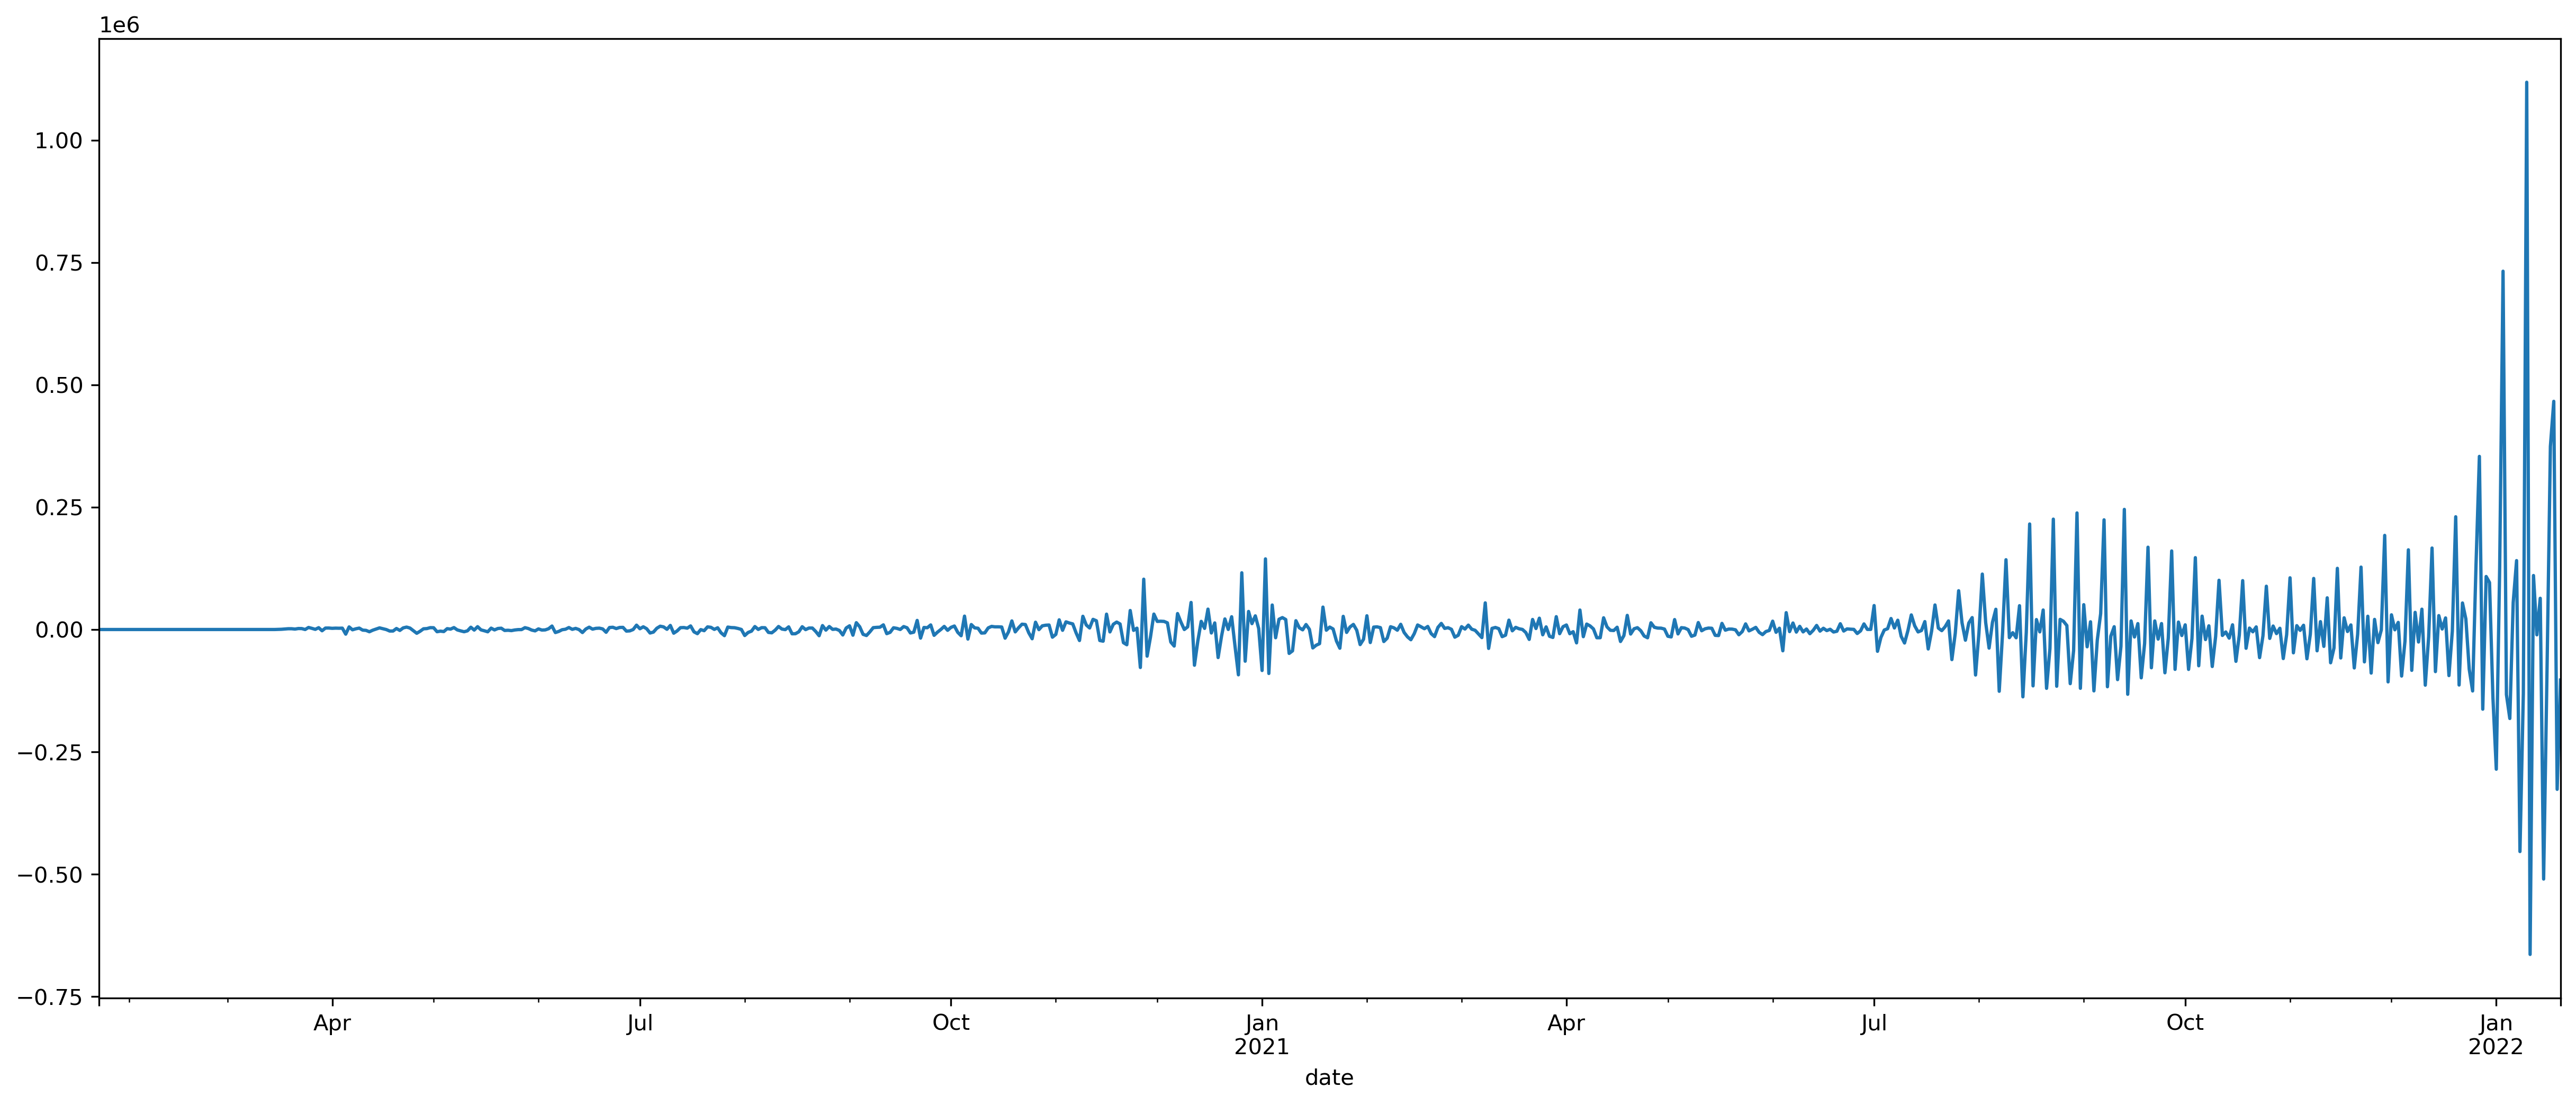

In [19]:
df['cases_diff2'] = df['cases_diff1'] - df['cases_diff1'].shift(1)
df['cases_diff2'].dropna().plot(figsize=(20, 8))
adf_test(df['cases_diff2'].dropna())

In [20]:
from statsmodels.tsa.statespace.tools import diff
df['cases_diff_2'] = diff(df['cases'],k_diff=2)

# Equivalent to:
# df1['d1'] = df1['Inventories'] - df1['Inventories'].shift(1)

adf_test(df['cases_diff_2'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -4.742825
p-value                   0.000070
# lags used              20.000000
# observations          708.000000
critical value (1%)      -3.439620
critical value (5%)      -2.865631
critical value (10%)     -2.568948
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and Stationary


In [21]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    
    if kpsstest[1] >= 0.05:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has no unit root and" + color.BOLD + color.RED +" Stationary" + color.END)
    else:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has a unit root and is" + color.BOLD + color.RED +" Non-Stationary" + color.END)
        
#p-value is greater than the significance level (for example, 0.05), the series is non-stationary. 

In [22]:
kpss_test(df['cases'])

Results of KPSS Test:
Test Statistic            4.091172
p-value                   0.010000
#Lags Used               17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has a unit root and is Non-Stationary


In [23]:
kpss_test(df['cases_diff1'].dropna())

Results of KPSS Test:
Test Statistic            1.031011
p-value                   0.010000
#Lags Used               16.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has a unit root and is Non-Stationary


In [24]:
kpss_test(df['cases_diff2'].dropna())

Results of KPSS Test:
Test Statistic           0.26979
p-value                  0.10000
#Lags Used               6.00000
Critical Value (10%)     0.34700
Critical Value (5%)      0.46300
Critical Value (2.5%)    0.57400
Critical Value (1%)      0.73900
dtype: float64
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has no unit root and Stationary


### Use <tt>pmdarima.auto_arima</tt> to determine ARIMA Orders

In [25]:
stepwise_fit = auto_arima(df['cases'], start_p=0, start_q=0,
                          max_p=3, max_q=3, m=3,
                          seasonal=False,
                          d=None, trace=True,
                          supress_warnings = False,
                          stepwise=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=18551.511, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=18486.137, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=18305.848, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=18549.631, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=18302.334, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=18248.370, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=18337.146, Time=0.07 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=18249.416, Time=0.14 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=18252.652, Time=0.14 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=18278.382, Time=0.11 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=18286.522, Time=0.05 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=18246.037, Time=0.21 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=18117.890, Time=0.64 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=18118.210, Time=0.55 sec
 ARIMA(3,2,3)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  731
Model:               SARIMAX(3, 2, 3)   Log Likelihood               -9050.945
Date:                Wed, 02 Feb 2022   AIC                          18117.890
Time:                        20:19:54   BIC                          18154.623
Sample:                             0   HQIC                         18132.063
                                - 731                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2850.2358   2253.177      1.265      0.206   -1565.909    7266.381
ar.L1         -0.3861      0.026    -14.868      0.000      -0.437      -0.335
ar.L2         -0.9638      0.009   -108.759      0.000      -0.981      -0.946
ar.L3          0.0616      0.026      2.367      0.018       0.011       0.113
ma.L1         -0.1688      0.025     -6.844      0.000      -0.217      -0.120
ma.L2          0.5345      0.020     26.956      0.000       0.496       0.573
ma.L3         -0.6996      0.022    -32.224      0.000      -0.742      -0.657
sigma2      4.149e+09      0.042   9.99e+10      0.000    4.15e+09    4.15e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             89882.46
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):             289.08   Skew:                             4.90
Prob(H) (two-sided):                  0.00   Kurtosis:                        56.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.17e+25. Standard errors may be unstable.
"""

This suggests that we should fit an <strong>ARIMA(3,2,3)</strong> model to best forecast future values of the series.

### Run the ACF and PACF plots

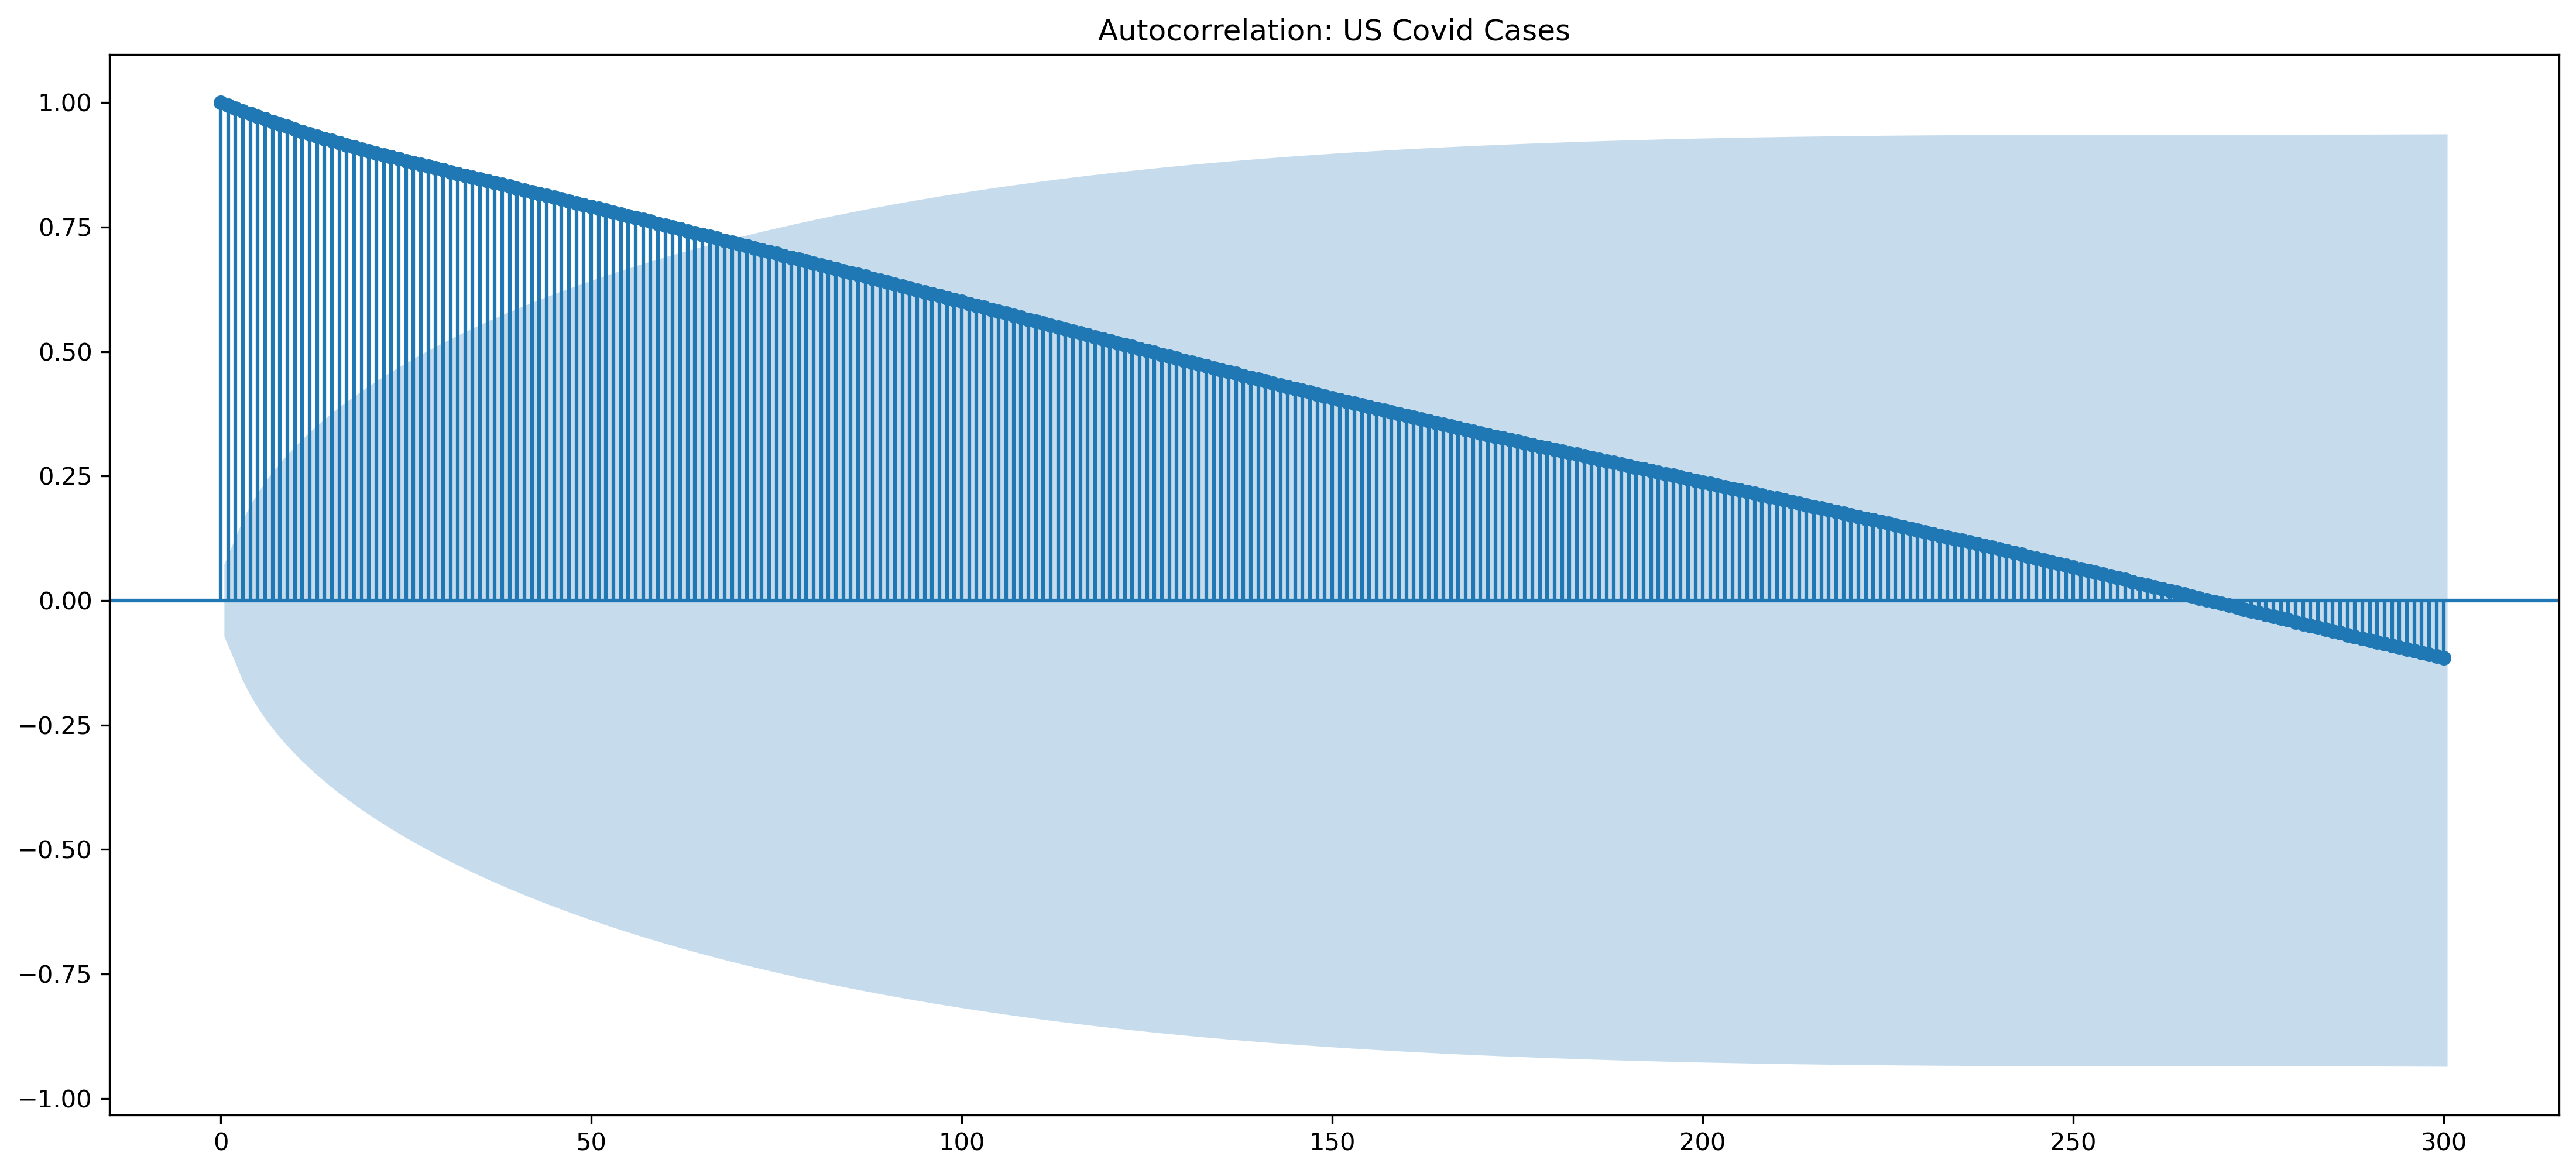

In [41]:
title = 'Autocorrelation: US Covid Cases'
lags = 300
plot_acf(df['cases'],title=title,lags=lags);

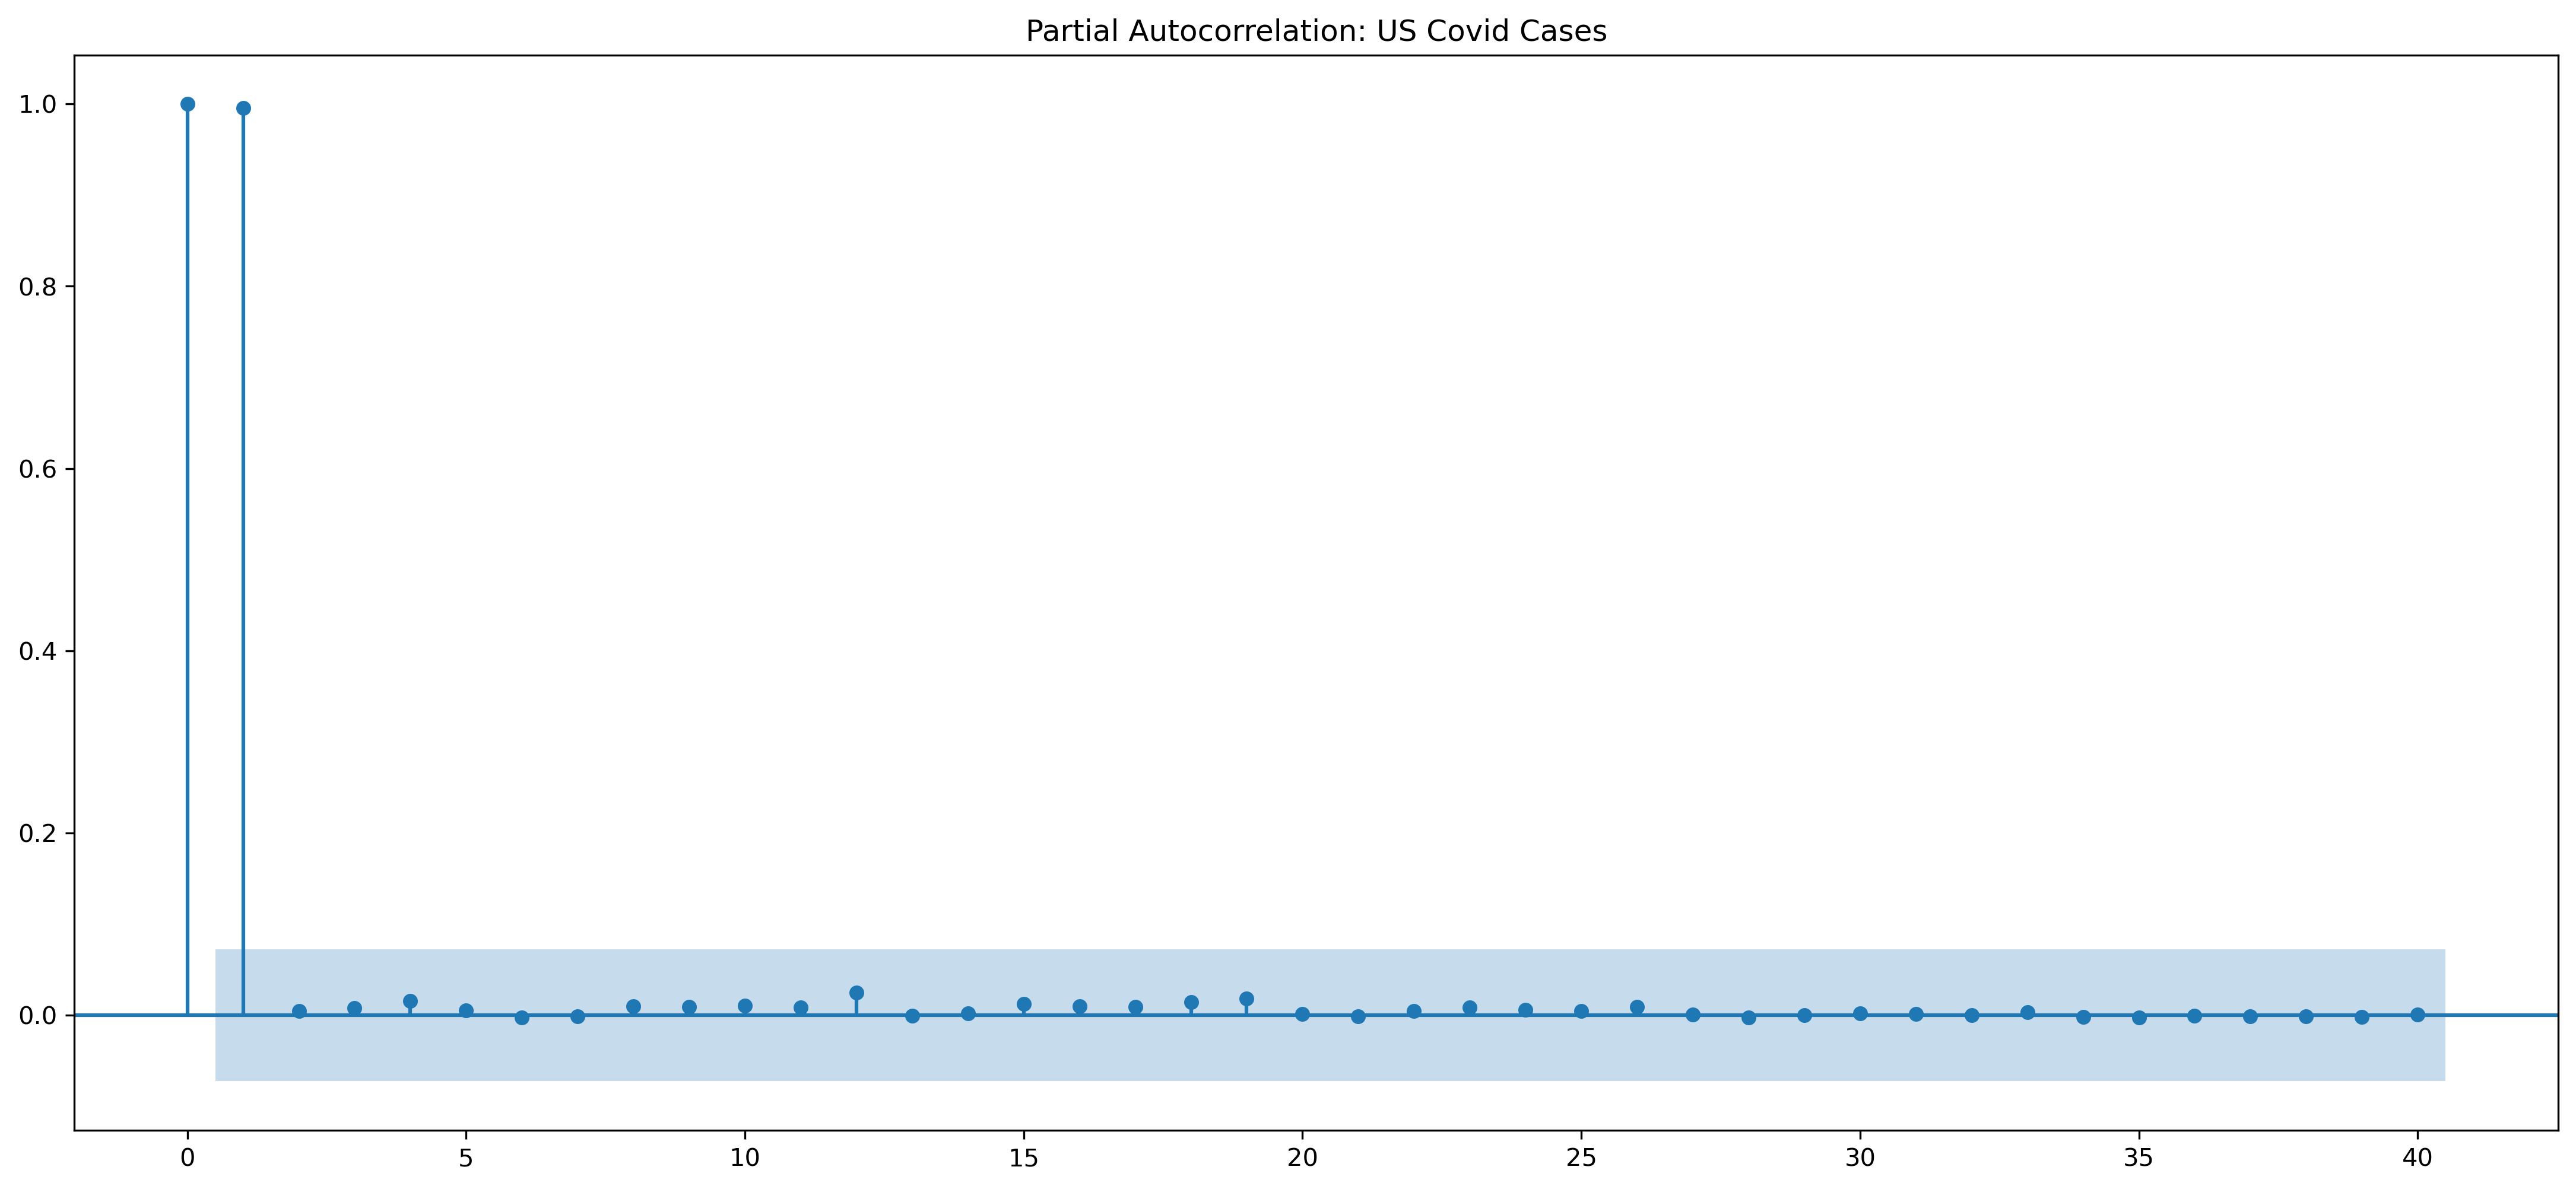

In [27]:
title = 'Partial Autocorrelation: US Covid Cases'
lags = 40
plot_pacf(df['cases'],title=title,lags=lags);

This tells us that the AR component should be more important than MA.

### Build ARIMA Model

In [28]:
# Set 50 days as test
l = len(df)
train = df.iloc[:l-50]
test = df.iloc[l-50:]

model = ARIMA(train['cases'],order=(3,2,3))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.cases   No. Observations:                  679
Model:                 ARIMA(3, 2, 3)   Log Likelihood               -7901.385
Method:                       css-mle   S.D. of innovations          27329.091
Date:                Wed, 02 Feb 2022   AIC                          15818.770
Time:                        20:19:55   BIC                          15854.935
Sample:                    01-23-2020   HQIC                         15832.770
                         - 12-01-2021                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            167.4925    249.403      0.672      0.502    -321.329     656.314
ar.L1.D2.cases    -0.1623      0.054     -3.008      0.003      -0.268      -0.057
ar.L2.D2.cases    -0.8678      0.026    -33.395      0.000      -0.919      -0.817
ar.L3.D2.cases     0.2392      0.049      4.898      0.000       0.143       0.335
ma.L1.D2.cases    -0.5320      0.041    -13.126      0.000      -0.611      -0.453
ma.L2.D2.cases     0.7020      0.031     22.692      0.000       0.641       0.763
ma.L3.D2.cases    -0.7466      0.024    -30.628      0.000      -0.794      -0.699
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2111           -0.9938j            1.0160           -0.2833
AR.2           -0.2111           +0.9938j            1.0160            0.2833
AR.3            4.0510           -0.0000j            4.0510           -0.0000
MA.1           -0.1490           -1.0293j            1.0400           -0.2729
MA.2           -0.1490           +1.0293j            1.0400            0.2729
MA.3            1.2383           -0.0000j            1.2383           -0.0000
-----------------------------------------------------------------------------
"""

In [29]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(3,2,3) Predictions')

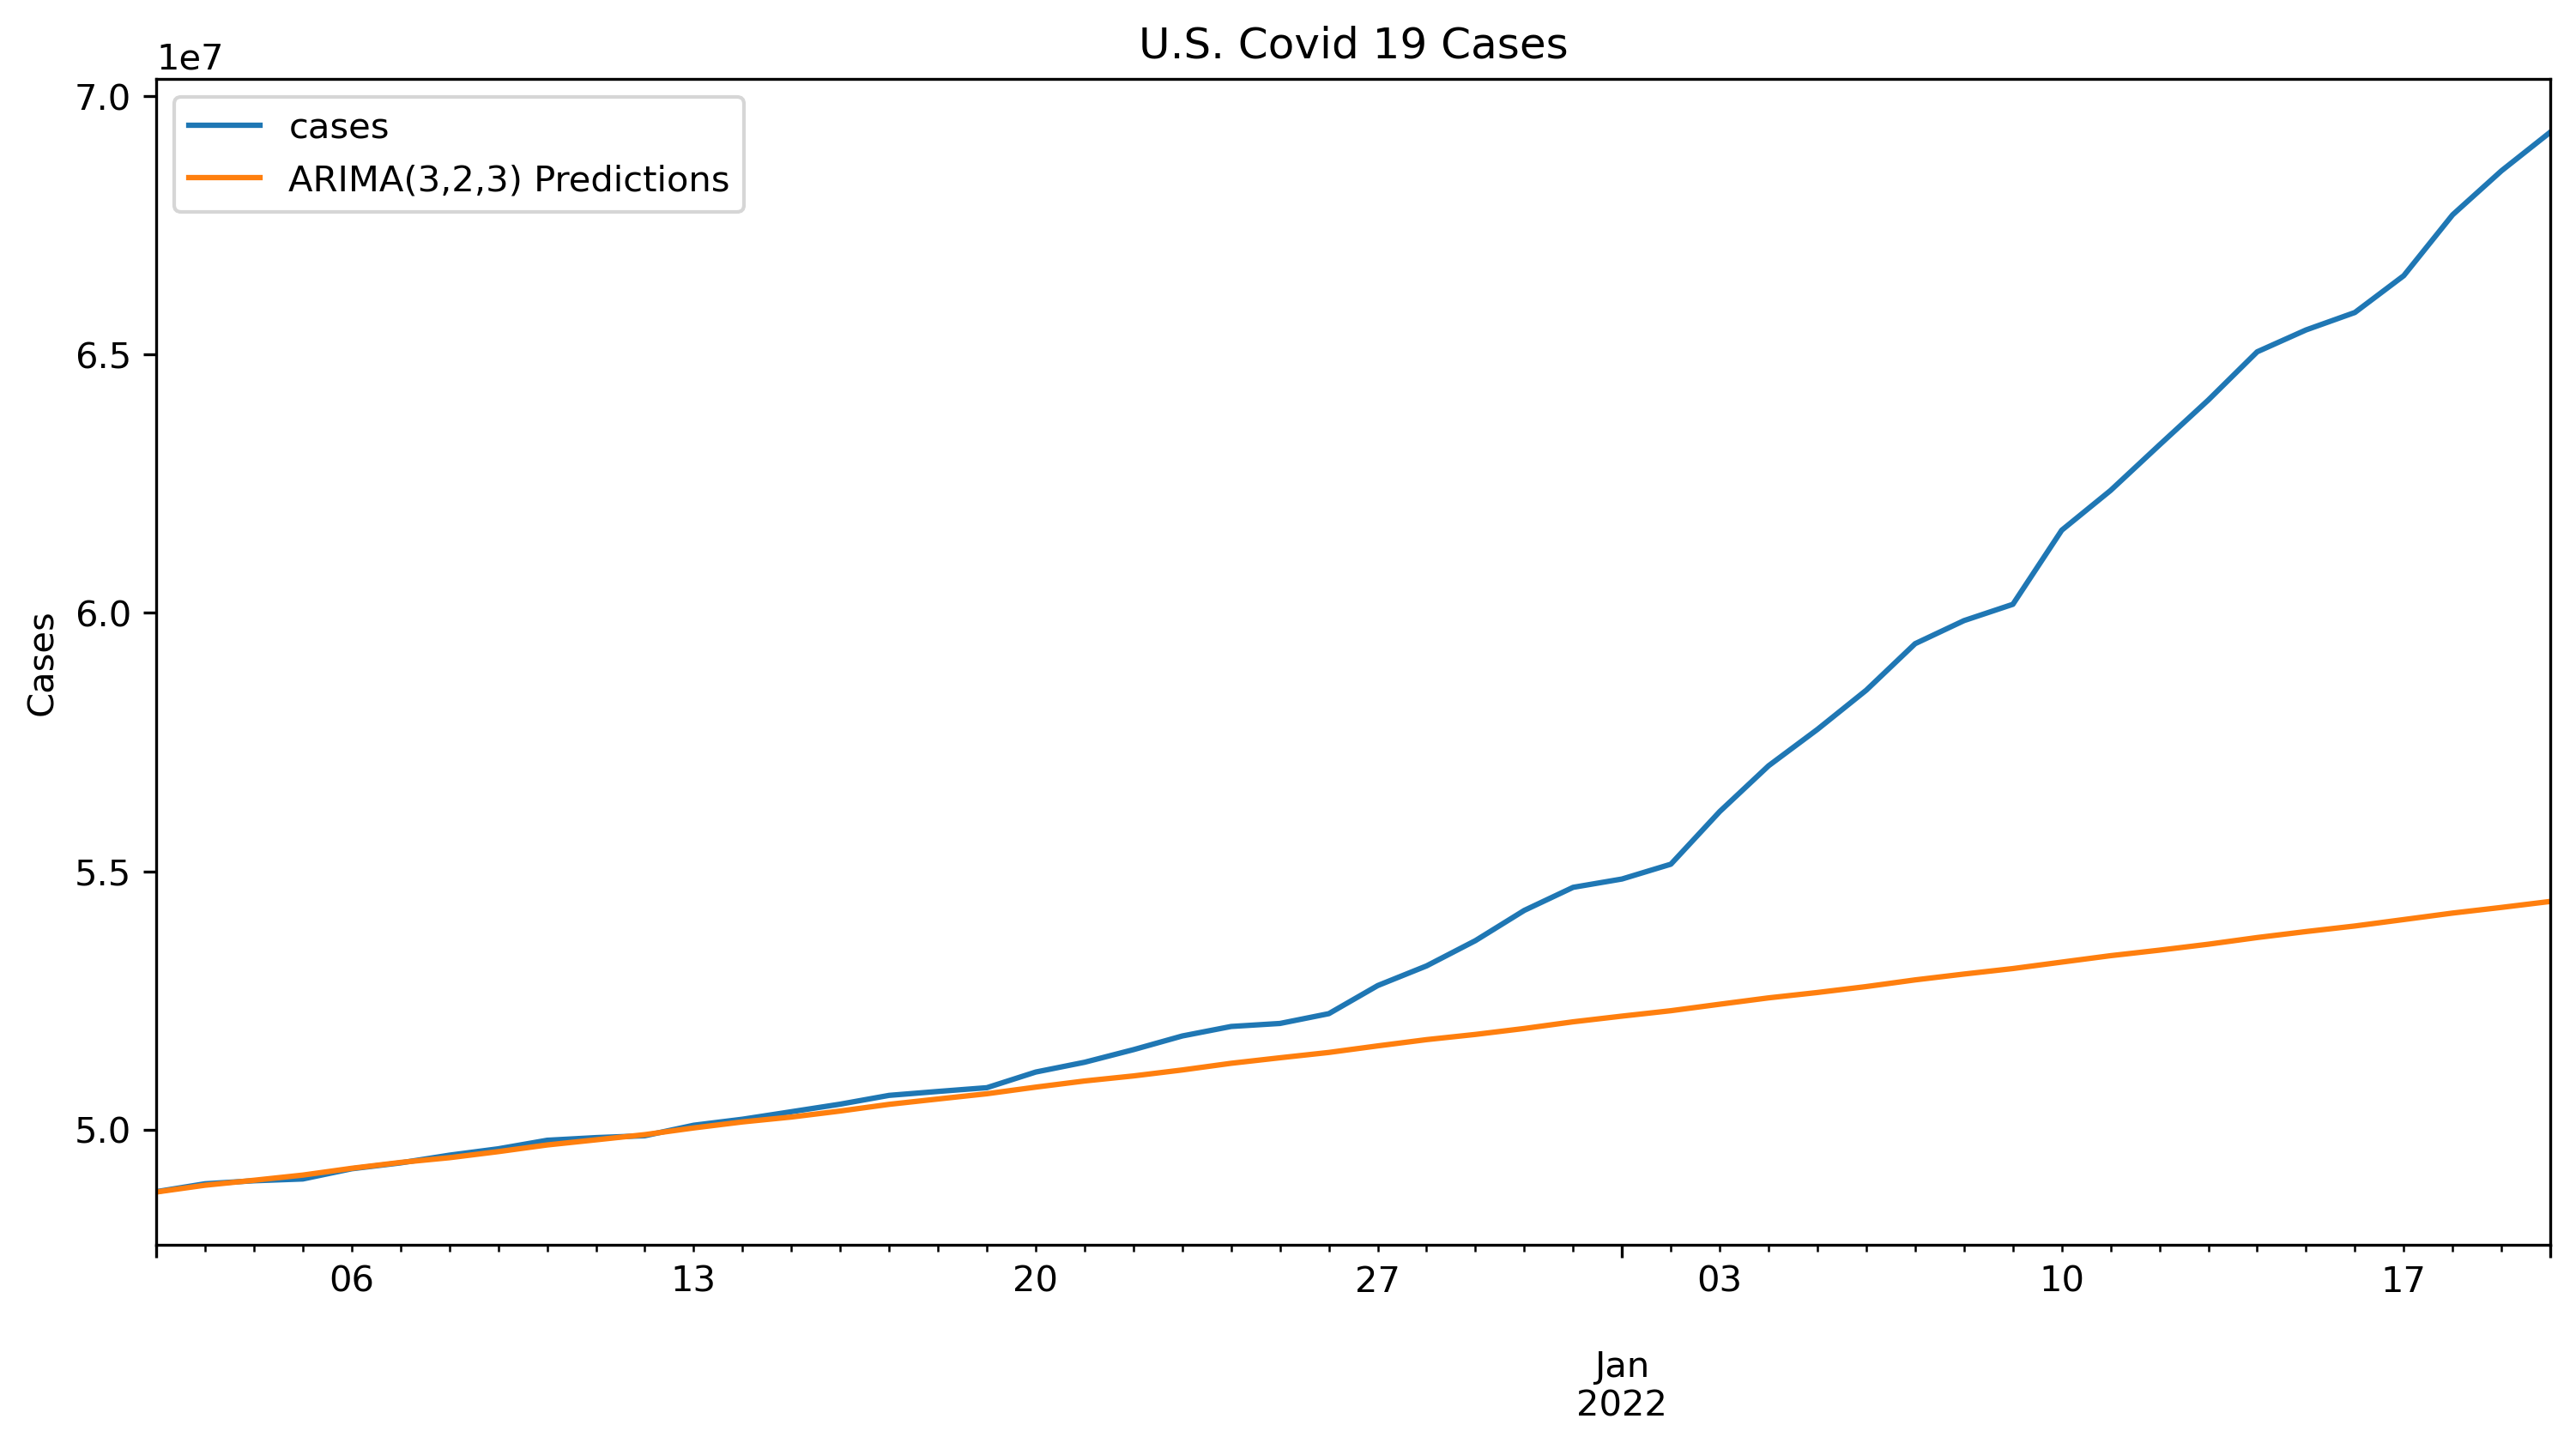

In [30]:
# Plot predictions against known values
title = 'U.S. Covid 19 Cases'
ylabel='Cases'
xlabel='' # we don't really need a label here

ax = test['cases'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

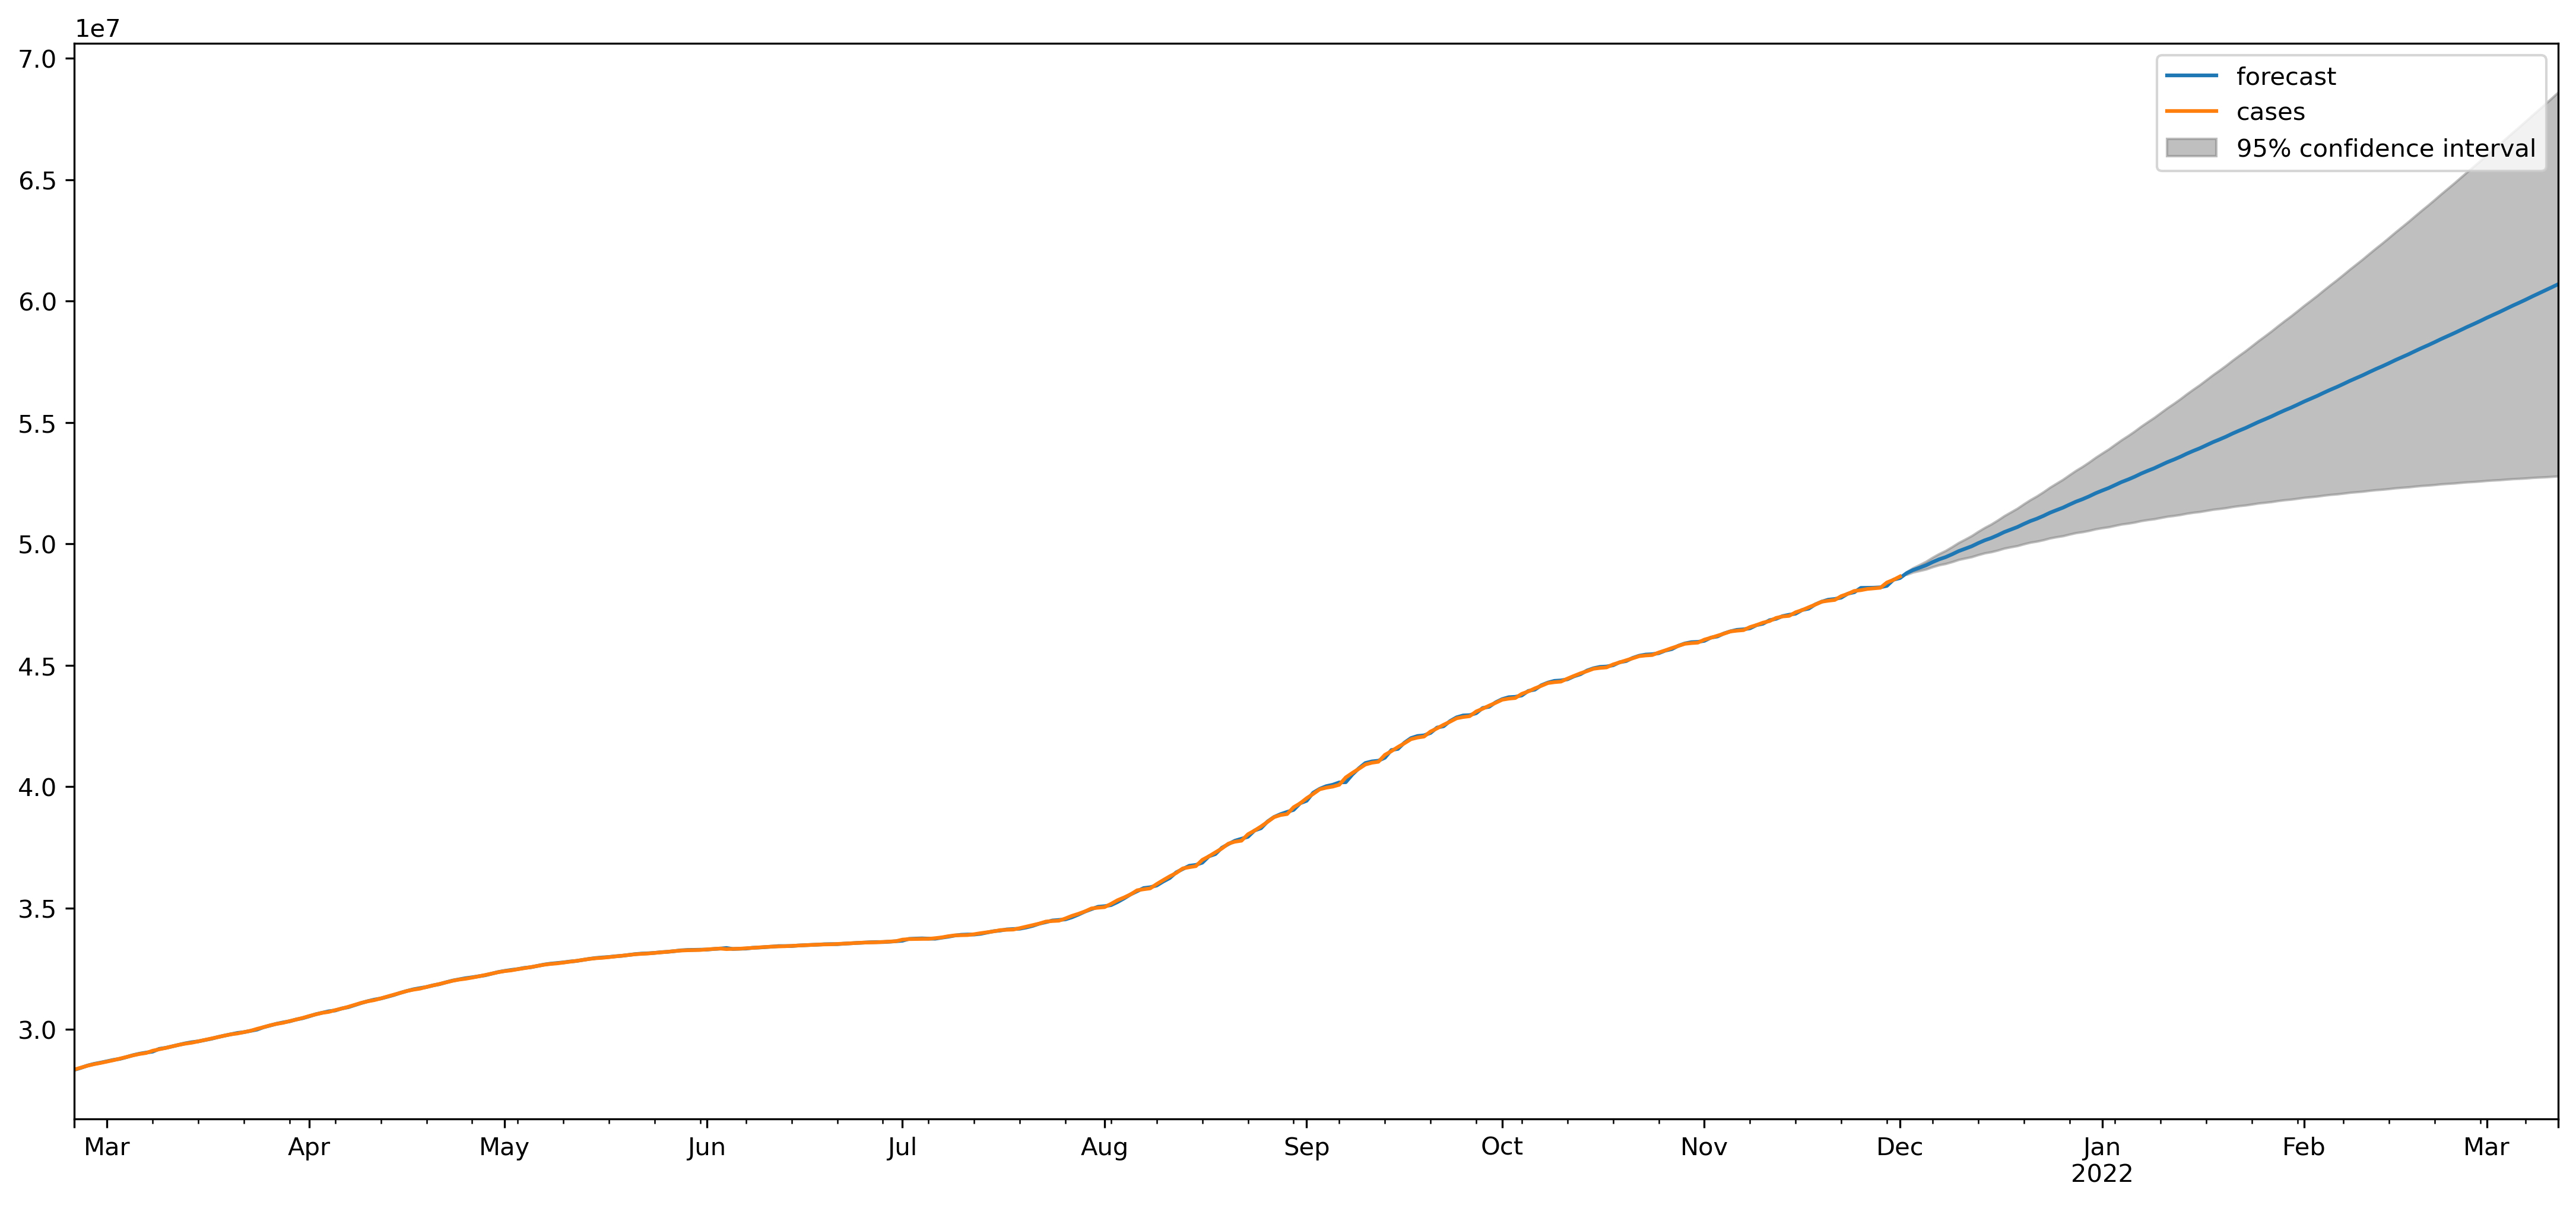

In [31]:
fcast = results.plot_predict(start = int(400), end = int(len(df)+50))

### Evaluation Metrics

In [32]:
error = int(np.sqrt(mean_squared_error(test.cases,predictions)))
mean = int(test.cases.mean())
error_rate = round((error/mean),5)
print(f'Error for test data is: {error}\n\
Mean for test data is: {mean}\n\
Error Rate is: {error_rate}\n')

Error for test data is: 5989188
Mean for test data is: 55313198
Error Rate is: 0.10828



### Retrain the model on the full data, and forecast the future

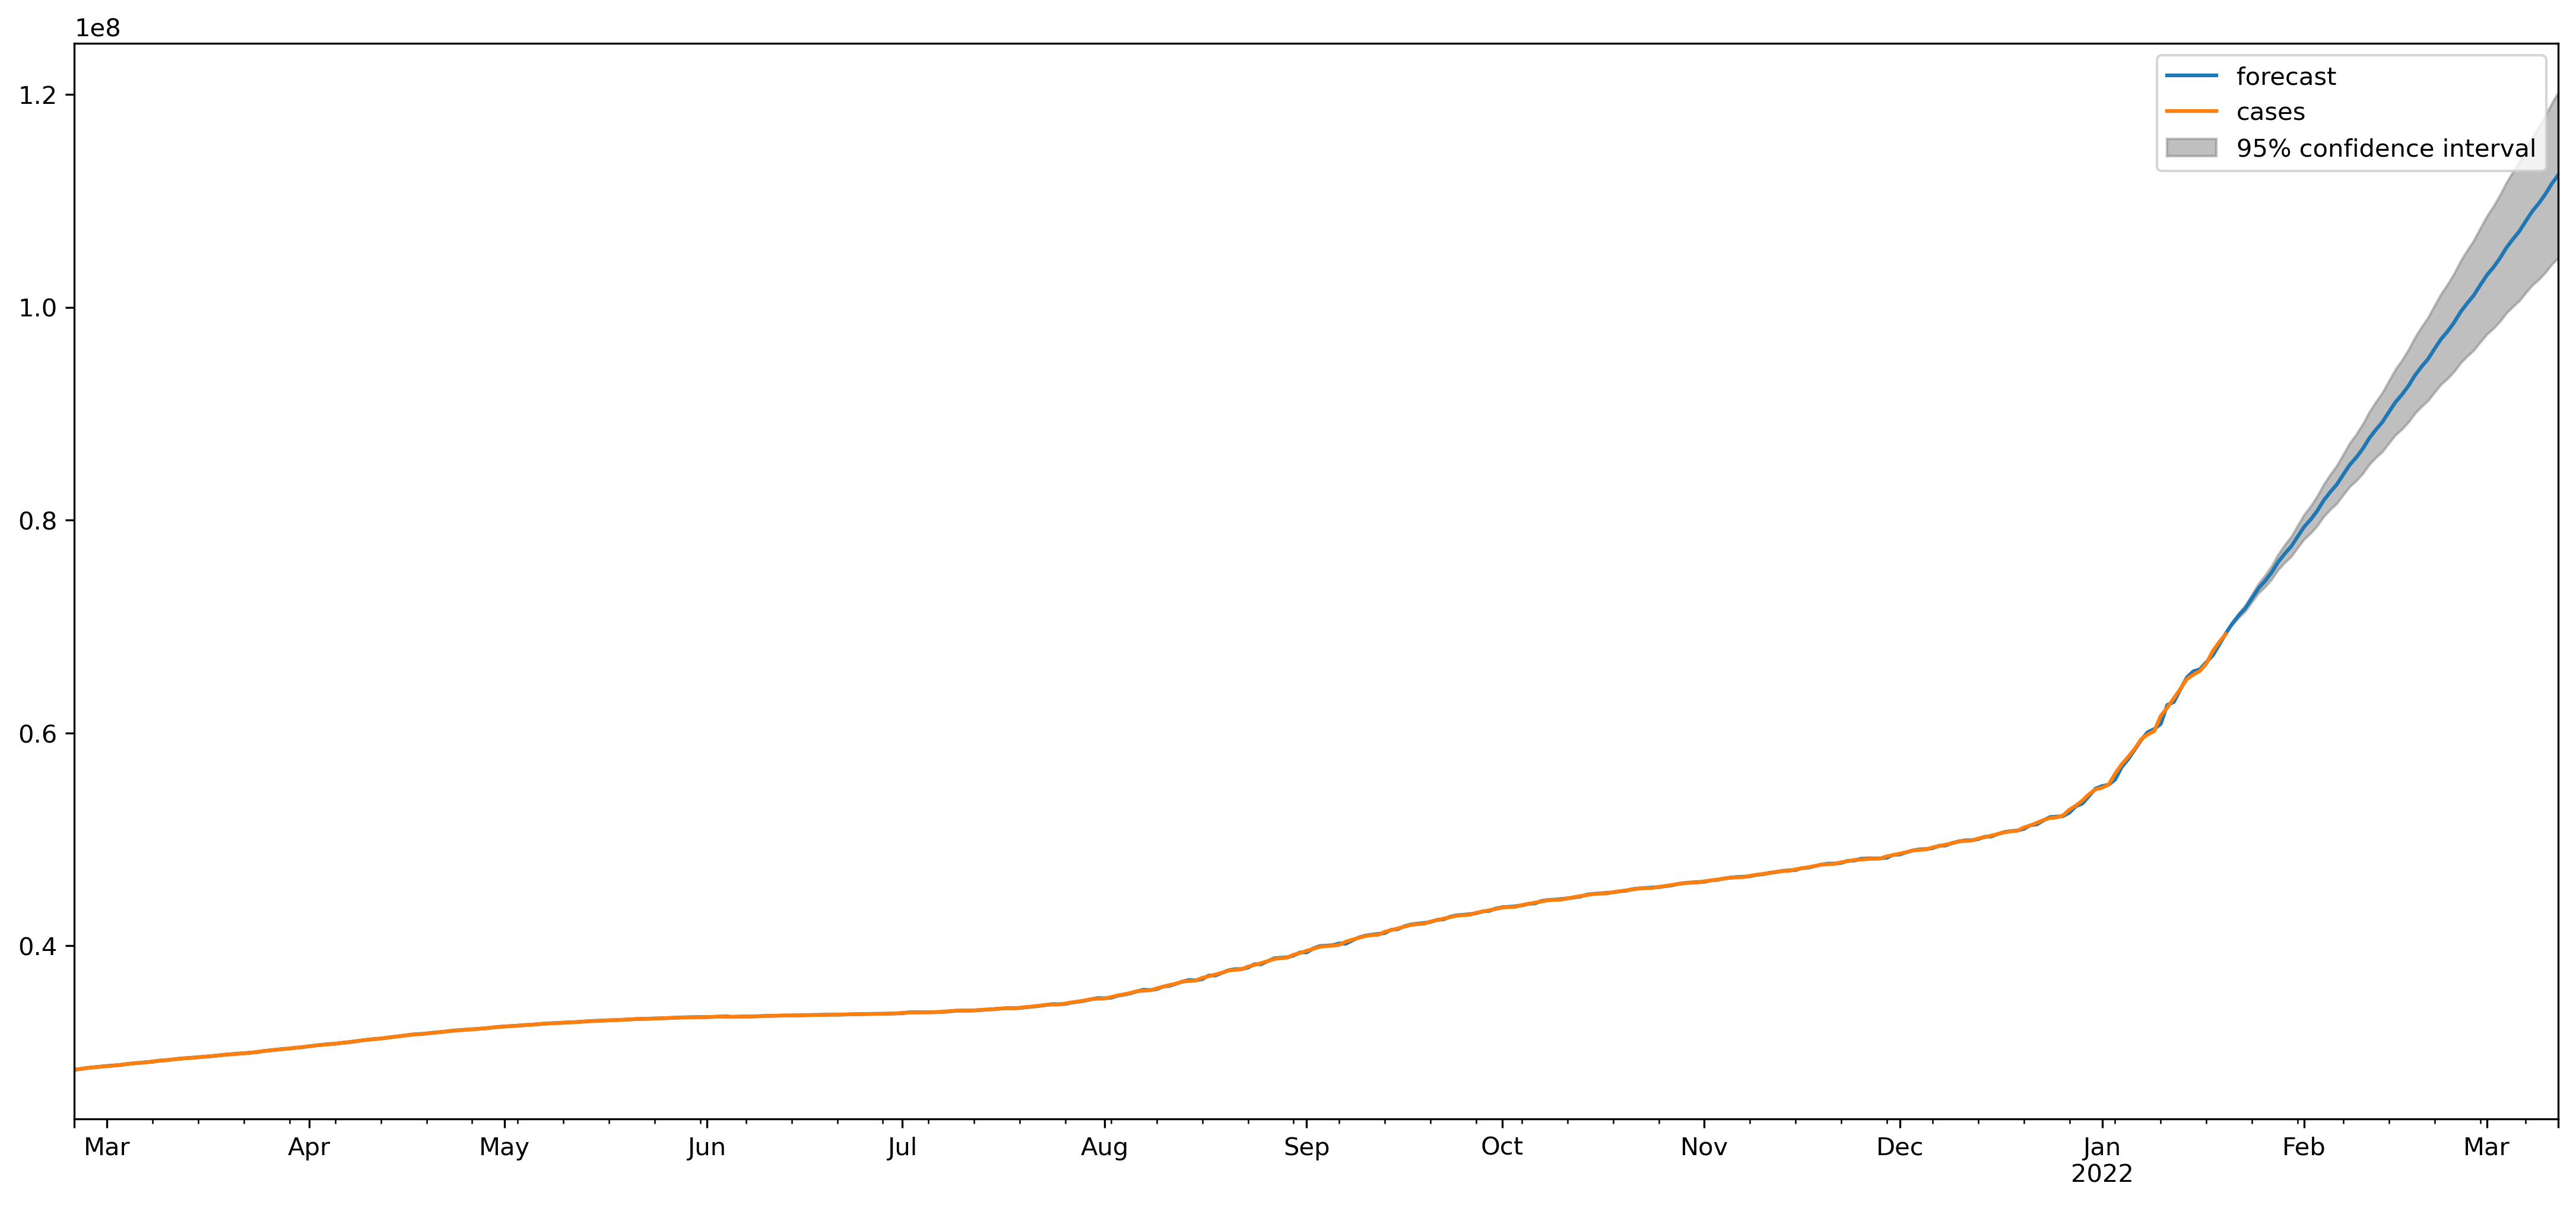

In [33]:
df = pd.read_csv('us.csv',index_col='date',parse_dates=True)

full_model = ARIMA(df['cases'],order=(3, 2, 3))
full_results = full_model.fit()
fcast = full_results.plot_predict(start = int(400), end = int(len(df)+50))